# Summary

By: Chengyi (Jeff) Chen

In [1]:
%load_ext autotime
%load_ext nb_black
%matplotlib inline

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# plt.rcParams["figure.dpi"] = 300
# plt.rcParams["figure.figsize"] = (16, 12)

import operator
import pandas as pd
import numpy as np
import cvxpy as cp
import scipy as sp
from scipy import optimize
import functools
from graphviz import Digraph
import dot2tex
from IPython.display import Latex
from sympy import *
import re

<IPython.core.display.Javascript object>

---
## Linear Programming

In [ ]:
# Create one vector optimization variable.
x = cp.Variable((2,), integer=False)

# Create constraints.
constraints = [
    np.array([[1, 1], [-1, 1]]) @ x <= np.array([2, 2]),
    x >= 0,
]

# Form objective.
obj = cp.Minimize(np.array([-1, -1]) @ x)

# Form and solve problem.
prob = cp.Problem(obj, constraints)
prob.solve()

print("Linear Programming Solution")
print("=" * 30)
print(f"Status: {prob.status}")
print(f"The optimal value is: {np.round(prob.value, 2)}")
print(f"The optimal solution is: x = {[np.round(x_i, 2) for x_i in x.value]}")

#### Optimality Conditions

In the Optimal Solution $\bar{x}$:
- Basic variables should be $> 0$ (unless it is a degenerate LP solution, in which there will also be basic variables $= 0$), while the non-basic variables $= 0$.
- The reduced cost coefficients $z_B - c_B = c^\top_B B^{-1}B - c_B = 0$ of the basic variables will be 0, while the reduced cost coefficients $z_N - c_N = c^\top_B B^{-1}N - c_N$ of the non-basic variables will be $\leq 0$ for a minimization problem and $\geq 0$ for a maximization problem.

In [2]:
reduced_cost_coefficients = lambda c_B, B, N, c_N: c_B.T @ (np.linalg.inv(B) @ N) - c_N

def optimal(c_B, B, N, c_N, problem_type="min"):
    assert problem_type == "min" or problem_type == "max", print("problem_type must be either 'min' or 'max'.")
    return np.alltrue(reduced_cost_coefficients(c_B, B, N, c_N) <= 0) if problem_type == "min" else np.alltrue(reduced_cost_coefficients(c_B, B, N, c_N) >= 0)

time: 636 µs


<IPython.core.display.Javascript object>

### Graphical Method

- What is an extreme point: if a linear programming problem in standard form has an optimal solution, then it has an optimal extreme point solution. (*Note that this theorem does not say that every optimal solution of a linear program is an extreme point.*)

In [ ]:
# Construct lines
x_1 = np.linspace(0, 20, 2000)  # x_1 >= 0
x_2_1 = lambda x_1: -x_1 + 2  # constraint 1: 𝑥1 + 𝑥2 ≥ 2
x_2_2 = lambda x_1: x_1 + 2  # constraint 2: −𝑥1 + 𝑥2 ≤ 2

# Make plot
plt.plot(x_1, x_2_1(x_1), label=r"$x_1 + x_2 \geq 2$")
plt.plot(x_1, x_2_2(x_1), label=r"$-x_1 + x_2 \leq 2$")
plt.xlim((0, 10))
plt.ylim((0, 10))
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")

# Fill feasible region
y = x_2_2(x_1)
x = np.maximum(x_2_1(x_1), np.zeros(len(x_1)))
plt.fill_between(x_1, x, y, where=y > x, color="grey", alpha=0.5)
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
plt.show()

### Revised Simplex Method

This is just basically the simplex method without all the other updating tableau stuff

1. Test for Optimality
    1. Find Pricing Vector $y = c_B B^{-1}$
    2. Compute $z_j = c_B B^{-1}N$
    3. Find non-basic index $j$ such that $z_N - c_N = \text{max}_{j\in N}{\{z_j - c_j\}}$. If $z_j - c_j \leq 0$, stop, current BFS is optimal
2. Min. Ratio Test
    1. Find $\bar{A}_{\bullet s} = B^{-1}A_{\bullet s}$
    2. If $\bar{a}_{is} \leq 0$ for all $i$, stop. The objective is unbounded below. Otherwise, find an index $r$ such that $\bar{a}_{is} > 0$ and $\frac{\bar{b}_r}{\bar{a}_{rs}} = \text{min}\Big\{\frac{\bar{b}_i}{\bar{a}_{is}}: \bar{a}_{is} > 0 \Big\}$
3. Update new basis, $A_{\bullet {j_r}}$ replaces $B_{\bullet {j_r}}$

### Duality

- Reduced cost coefficients corresponding to the primal slack variables are the values of the dual variables of optimal dual solution.

In [ ]:
primal_feasible = lambda B, b: np.alltrue(np.linalg.inv(B) @ b >= 0)
dual_feasible = lambda 

In [ ]:
# Optimal Dual from Optimal Basis and RHS of constraints 
y = lambda B, c_B: c_B @ np.linalg.inv(B)

### Dual Simplex

- Start off just like normal simplex with slack vars in the tableau, but with primal optimality ($c^\top_B B^{-1}N - c_N \leq / \geq 0$ for min / max problem) and primal **infeasibility** ($B^{-1}b \leq 0$).
- Choose most negative row of $B^{-1}b$ as leaving variable
- Choose all the elements in that row with negative values
- Choose entering variable as column with max of reduced cost coefficients / |row with negative values|
- Pivotting operations and repeat until primal feasibility and primal optimality is achieved.

### Recovery of Final Simplex Tableau if Optimal Feasible Basis $B$ is known

Basic Row values: Identity Matrix

Non-basic Row values: $B^{-1}N$

Objective Value: $c_B B^{-1}b$

RHS Values: $B^{-1}b$

Negative Reduced Cost Coefficients for Non-basic Variables: ${c_B}^\top B^{-1} N - c_N$

Negative Reduced Cost Coefficients for Basic Variables: 0

### Parametric Linear Programming

#### Parametric Objective Function 

\begin{align}
    \text{minimize } &(c + \lambda d)^\top x \\
    \text{subject to } &Ax = b \\
    &x \geq 0 \\
\end{align}

- If a basis is to remain optimal after adding the $\lambda$ to the coefficients, it must satisfy the optimality conditions of reduced cost coefficients $\leq 0$ / $\geq 0$ for min / max problem.
- If basis isn't optimal anymore, find a new basis by making the entering variable the one with reduced cost coefficient causing the most problem and leaving by min ratio test $\min(\frac{\bar{b}_{\text{row idx}}}{a_{\text{row idx}\text{col idx of entering variable}}})$

### Sensitivity Analysis

In [ ]:
def c_range(A, c, basic_var_idxs, problem_type="min"):
    assert problem_type == "min" or problem_type == "max", print(
        "problem_type must be either 'min' or 'max'."
    )
    nonbasic_var_idxs = [idx for idx in range(len(c)) if idx not in basic_var_idxs]
    B, N = A[:, basic_var_idxs], A[:, nonbasic_var_idxs]
    B_inv = np.linalg.inv(B)
    for idx in range(len(c)):
        if idx in basic_var_idxs:
            RHS_basic_var_cost_coeffs = -(B_inv @ N)[list(basic_var_idxs).index(idx), :]
            LHS = (
                c[
                    [
                        basic_var_idx
                        for basic_var_idx in basic_var_idxs
                        if basic_var_idx != idx
                    ]
                ].T
                @ (B_inv @ N)[
                    [
                        i
                        for i in range(len(basic_var_idxs))
                        if i != list(basic_var_idxs).index(idx)
                    ],
                    :,
                ]
                - c[nonbasic_var_idxs]
            )
            c_lb_RHS_basic_var_cost_coeffs_idxs = np.argwhere(
                np.array(RHS_basic_var_cost_coeffs) > 0
            ).flatten()
            c_ub_RHS_basic_var_cost_coeffs_idxs = np.argwhere(
                np.array(RHS_basic_var_cost_coeffs) < 0
            ).flatten()
            c_lb_candidates = (
                (
                    LHS[c_lb_RHS_basic_var_cost_coeffs_idxs]
                    / RHS_basic_var_cost_coeffs[c_lb_RHS_basic_var_cost_coeffs_idxs]
                )
                if len(c_lb_RHS_basic_var_cost_coeffs_idxs) > 0
                else []
            )
            c_ub_candidates = (
                (
                    LHS[c_ub_RHS_basic_var_cost_coeffs_idxs]
                    / RHS_basic_var_cost_coeffs[c_ub_RHS_basic_var_cost_coeffs_idxs]
                )
                if len(c_ub_RHS_basic_var_cost_coeffs_idxs) > 0
                else []
            )
            c_lb = max(c_lb_candidates) if len(c_lb_candidates) > 0 else -np.inf
            c_ub = min(c_ub_candidates) if len(c_ub_candidates) > 0 else np.inf
            print(f"{c_lb} <= c_{idx+1} <= {c_ub}")
        else:
            print(
                f"c_{idx+1} >= {c[basic_var_idxs].T @ (B_inv @ N)[:, list(nonbasic_var_idxs).index(idx)]}"
            )

#### 4. Changes in RHS of Primal Constraints $b$ in $Ax = b$

- Check that $B^{-1}b + B^{-1}\delta \geq 0$ for all the primal constraints.
- Note that changing $b$ does not affect optimality since optimality depends on the reduced cost coefficients $z_N - c_N = c^\top_B B^{-1}N - c_N$

In [ ]:
def δb_range(B, b):
    B_inv = np.linalg.inv(B)
    b_bar = B_inv @ b
    for row_idx in range(B_inv.shape[0]):
        δ_candidates = -b_bar / B_inv[:, row_idx]
        δ_ub, δ_lb = (
            min(δ_candidates[np.sign(B_inv[:, row_idx]) < 0]) if len(δ_candidates[np.sign(B_inv[:, row_idx]) < 0]) > 0 else np.inf,
            max(δ_candidates[np.sign(B_inv[:, row_idx]) > 0]) if len(δ_candidates[np.sign(B_inv[:, row_idx]) > 0]) > 0 else -np.inf,
        )
        if np.allclose(δ_ub, 0):
            δ_ub = 0
        if np.allclose(δ_lb, 0):
            δ_lb = 0
        if δ_ub == 0 and δ_lb == 0:
            print(f"δ_{row_idx+1} cannot be perturbed.")
        else:
            print(f"{δ_lb} <= δ_{row_idx+1} <= {δ_ub}.")

        # Feasibility Checks
        assert np.alltrue(δ_lb * np.linalg.inv(B)[:, row_idx] >= -b_bar), print(
            "δ_lb", δ_lb * np.linalg.inv(B)[:, row_idx], -b_bar
        )
        assert np.alltrue(δ_ub * np.linalg.inv(B)[:, row_idx] >= -b_bar), print(
            "δ_ub", δ_ub * np.linalg.inv(B)[:, row_idx], -b_bar
        )

---
## Unconstrained Optimization

### Root-Finding Methods

#### Bisection Method

In [3]:
def bisection_root_finding(f, interval=[2, 6], δ=1e-05):
    assert (len(interval) == 2) & (
        interval[1] > interval[0]
    ), "interval must only have 2 values and b > a."
    root_candidate = np.mean(interval)
    while True:
        # 1. If |b−a| ≤ δ or f(c)=0, stop and report the zero as x∗=c.
        if np.allclose(np.abs(interval[1] - interval[0]), 0, rtol=δ) or np.allclose(
            f(root_candidate), 0, rtol=1e-5
        ):
            return root_candidate

        # 2. If f(a)f(c)>0, let a←c else let b←c to create a new interval.
        print(
            f"x = ({np.round(interval, 5)}/2) = {np.round(root_candidate, 5)}",
            f"g(x) = {np.round(f(root_candidate), 5)}",
        )
        if np.prod(np.sign([f(root_candidate), f(interval[1])])) < 0:
            interval = [root_candidate, interval[1]]
        else:
            interval = [interval[0], root_candidate]

        # 3. Find the midpoint c of the new interval and evaluate f(c).
        root_candidate = np.mean(interval)

    return root_candidate

time: 2.25 ms


<IPython.core.display.Javascript object>

#### Newton's Method

In [5]:
def newton_raphson_root_finding(f, f_prime, x_0, δ=1e-05):
    x_k = x_0  # x_k
    while True:
        print(f"New root candidate: {x_k}")
        # 1. If |f(xk)| ≤ δ, stop and report a zero of f as x∗ = xk.
        if np.allclose(f(x_k), 0, rtol=δ):
            return x_k

        # 2. Determine pk = −f(xk)/f′(xk)
        p_k = -f(x_k) / f_prime(x_k)

        # 3. Set the steplength αk = 1.
        α_k = 1

        # 4. Let xk+1 = xk + αkpk = xk − f(xk)/f′(xk), and compute f(xk+1).
        x_k += α_k * p_k

        # 5. Let k←k+1 and return to Step 1.

    return x_k

time: 1.18 ms


<IPython.core.display.Javascript object>

#### Secant Method

In [7]:
def secant_root_finding(f, x_0, x_1, δ=1e-05):
    x_k, x_k_1 = x_1, x_0  # x_k, x_k-1
    while True:
        print(f"New root candidate: {x_k}")
        # 1. If |f(xk)| ≤ δ, stop and report a zero of f as x∗ = xk.
        if np.allclose(f(x_k), 0, rtol=δ):
            return x_k

        # 2. Determine pk = −f(xk) [(xk − xk−1) / (f(xk) − f(xk−1))].
        p_k = -f(x_k) * ((x_k - x_k_1) / (f(x_k) - f(x_k_1)))

        # 3. Set the steplength αk = 1.
        α_k = 1

        # 4. Let xk+1 = xk +αkpk = xk −f(xk) [(xk − xk−1) / (f(xk) − f(xk−1))], and compute f(xk+1).
        x_k_1 = x_k
        x_k += α_k * p_k

        # 5. Let k←k+1 and return to Step 1.

    return x_k

time: 1.48 ms


<IPython.core.display.Javascript object>

#### Regula Falsi Method

In [9]:
def regula_falsi_root_finding(f, x_0, x_1, δ=1e-05):
    assert (
        f(x_0) * f(x_1) < 0
    ), "f(x_0)f(x_1) < 0, choose another pair of values for x_0 and x_1."
    x_k, x_k_1 = x_1, x_0  # x_k, x_k-1
    while True:
        print(f"New root candidate: {x_k}")
        # 1. If |f(xk)| ≤ δ, stop and report a zero of f as x∗ = xk.
        if np.allclose(f(x_k), 0, rtol=δ):
            return x_k

        # 2. Determine pk = −f(xk) [(xk − xk−1) / (f(xk) − f(xk−1))].
        p_k = -f(x_k) * ((x_k - x_k_1) / (f(x_k) - f(x_k_1)))

        # 3. Set the steplength αk = 1.
        α_k = 1

        # 5. If f(xk+1)f(xk−1) < 0, set xk = xk−1.
        if f(x_k + α_k * p_k) * f(x_k_1) < 0:
            x_k_1 = x_k

        # 4. Let xk+1 = xk +αkpk = xk −f(xk) [(xk − xk−1) / (f(xk) − f(xk−1))], and compute f(xk+1).
        x_k += α_k * p_k

        # 6. Let k←k+1 and return to Step 1.

    return x_k

time: 1.7 ms


<IPython.core.display.Javascript object>

### Optimization Methods

In [ ]:
def simple_steplength(f, f_prime, x_k, p_k, μ=1e-4):
    # 1. Set α=1.
    α = 1
    while True:
        # 2. If f(xk+αpk) ≤ f(xk)+μαgkpk, set αk=α and stop.
        if f(x_k + α * p_k) <= f(x_k) + μ * α * f_prime(x_k).T @ p_k:
            return α
        else:
            # 3. Set α=α/2 and go to Step2.
            α /= 2

In [ ]:
def line_search(f, f_prime, x_k, p_k, μ=1e-4, η=1):
    """α = argmin_α f(xk + αpk), η=1 for exact, η small for accurate line search"""
    # 1. Set α=1.
    α = 1
    while True:
        # 2. Wolfe conditions:
        # If f(xk+αpk) ≤ f(xk)+μαgkpk, and |g(x+αpk).Tpk| ≤ η|g(xk).Tpk|, set αk=α and stop.
        if f(x_k + α * p_k) <= f(x_k) + μ * α * f_prime(x_k).T @ p_k and np.abs(
            f_prime(x_k + α * p_k).T @ p_k
        ) <= η * np.abs(f_prime(x_k).T @ p_k):
            return α
        else:
            # 3. Set α=α/2 and go to Step2.
            α /= 2

In [1]:
def armijo_line_search(f, f_prime, x_k, p_k, ρ=0.8, σ=0.8):
    """Armijo Backtracking Line Search
    
    Args:
        ρ: Backtracking factor
        σ: Bending factor
    """
    m = 0
    while True:
        α = ρ**m
        if f(x_k + α*p_k) <= f(x_k) + σ*α*f_prime(x_k).T@p_k:
            return α
        else:
            m += 1

In [ ]:
def steepest_descent(f, f_prime, x_0, ε=1e-15, steplength_algo=simple_steplength):
    k, x_k = 0, x_0
    while True:

        # 1. Test for Convergence
        if np.allclose(f_prime(x_k), 0, rtol=ε):
            return x_k

        # 2. Compute a search direction
        p_k = -f_prime(x_k)

        # 3. Compute a steplength
        α_k = steplength_algo(f=f, f_prime=f_prime, x_k=x_k, p_k=p_k, μ=1e-4)

        print(
            f"Iteration: {k} - x_{k} = {np.round(x_k, 5)}, p_k = {np.round(p_k, 5)}, α_k = {np.round(α_k, 5)}"
        )

        # 4. Update the iterate and return to Step 1
        k += 1
        x_k += α_k * p_k

        # Check for divergence
        if np.allclose(x_k, x_k + α_k * p_k) and k > 1:
            print("Series diverged.")
            break

In [ ]:
def newton_raphson_opt(
    f, f_prime, hessian, x_0, ε=1e-15, steplength_algo=simple_steplength
):
    """This method here is exactly the same as the 
    Newton method for root finding except that f is 
    the function we're trying to find the optimum point
    for  - using the newton raphson root finding but for
    the derivative of f, and this method is applicable to
    higher dimensions
    """
    k, x_k = 0, x_0
    while True:

        # 1. Test for Convergence
        if np.allclose(f_prime(x=x_k), 0, rtol=ε):
            return x_k

        # 2. Compute a search direction
        p_k = -np.linalg.inv(hessian(x=x_k)) @ f_prime(x=x_k)

        # 3. Compute a steplength
        α_k = steplength_algo(f=f, f_prime=f_prime, x_k=x_k, p_k=p_k, μ=1e-4)

        print(
            f"Iteration: {k} - x_{k} = {np.round(x_k, 5)}, p_k = {np.round(p_k, 5)}, α_k = {np.round(α_k, 5)}, hessian = {np.round(hessian(x=x_k), 5)}"
        )

        # 4. Update the iterate and return to Step 1
        k += 1
        x_k += α_k * p_k

        # Check for divergence
        if np.allclose(x_k, x_k + α_k * p_k) and k > 1:
            print("Series diverged.")
            break

---
## Duality

- Optimize primal with general constraints Vs. Optimize dual with simple constraints

Proof of Weak Duality

---
## KKT

- to use KKT to find optimal solution, we need constraint qualifications
- LICQ is a special case of MFCQ if there are no inequality constraints

---
## Integer Programming

In [2]:
# Converts the optimization problem parameters into the mathematical representation
def solve_lp(x, constraints, obj_coeff, problem_type):
    """Solves the standard LP maximization problem and creates the 
    mathematical formulation of optimization label for graphviz
    """
    obj = cp.Maximize(obj_coeff @ x)
    prob = cp.Problem(obj, constraints)
    prob.solve()

    label = (
        f"{problem_type} {' + '.join([str(coeff) + 'x' + str(i+1) for coeff, i in zip(obj_coeff, range(x.shape[0]))])} "
        + "\nsubject to: \n"
        + "{}".format(
            "\n".join(
                [
                    re.sub(
                        r"x\[([0-9]*)\]",
                        "x"
                        + str(
                            int(
                                re.search(
                                    r"\[[0-9]*\]",
                                    re.sub(r"var[0-9]*", "x", str(constraint)),
                                )
                                .group()
                                .replace("]", "")
                                .replace("[", "")
                            )
                            + 1
                        ),
                        re.sub(r"var[0-9]*", "x", str(constraint)),
                    )
                    if re.search(
                        r"x\[([0-9]*)\]", re.sub(r"var[0-9]*", "x", str(constraint))
                    )
                    is not None
                    else re.sub(r"var[0-9]*", "x", str(constraint))
                    for constraint in constraints
                ]
            )
        )
        + (
            "\n\nObjective Value: "
            + (
                str(np.round(prob.value, 2))
                if prob.status == "optimal"
                else str(prob.value)
            )
            + "\nSolution: "
            + (
                str([np.round(x_i, 2) for x_i in x.value])
                if prob.status == "optimal"
                else prob.status
            )
        )
    )
    return label, prob


# Checks if the number is an integer within specified decimal rounding
is_integer = lambda x, decimals=3: np.round(x, decimals).is_integer()

# Checks if all elements in array are integers
is_integer_solution = lambda x: np.alltrue([is_integer(x_i) for x_i in x])


def branch_and_bound_dfs(root, x, constraints, obj_coeff, problem_type):
    """Iterative DFS traversal of branch and bound tree"""

    node_id = "root"  # ID to map the node of branch and bound tree to the constraints
    stack = (
        []
    )  # To simulate depth first traversal by appending onto stack the node's children
    node_constraints = (
        {}
    )  # A map of the node_id to constraints associated with the node
    visited = []  # A list to keep the nodes already visited

    stack.append((node_id, None))
    node_constraints[node_id] = constraints

    lb, ub = None, None  # Lower bound and upper bound of ILP

    while len(stack) > 0:

        # Visit node
        node_id, parent_node_id = stack.pop()
        visited.append(node_id)

        # Process Root
        label, prob = solve_lp(x, node_constraints[node_id], obj_coeff, problem_type)
        root.node(name=str(node_id), label=label)

        # Add Edge
        if node_id != "root":
            root.edge(
                tail_name=str(parent_node_id),
                head_name=str(node_id),
                label=re.sub(
                    r"x\[([0-9]*)\]",
                    "x"
                    + str(
                        int(
                            re.search(
                                r"\[[0-9]*\]",
                                re.sub(
                                    r"var[0-9]*",
                                    "x",
                                    str(node_constraints[node_id][-1]),
                                ),
                            )
                            .group()
                            .replace("]", "")
                            .replace("[", "")
                        )
                        + 1
                    ),
                    re.sub(r"var[0-9]*", "x", str(node_constraints[node_id][-1])),
                ),
                len="5",
            )

        if prob.status == "optimal":

            # If current solution is integer
            is_integer_current_solution = is_integer_solution(
                np.array(list(prob.solution.primal_vars.values())).flatten()
            )

            # Break Conditions
            if is_integer_current_solution and (
                (ub is None) or (prob.value == np.floor(ub.value))
            ):  # Optimal Integer solution found
                return root, prob

            # Set lower bound of the ilp
            if is_integer_current_solution and (
                (lb is None) or (prob.value > lb.value)
            ):
                lb = prob

            # Set upper bound of the ilp
            if (ub is None) or (prob.value > ub.value):
                ub = prob

            if (
                prob.value > lb.value if lb is not None else True
            ) and not is_integer_current_solution:

                # Find non-integer value of solution
                largest_nonint_idx, largest_nonint_val = sorted(
                    [
                        (idx, x_i)
                        for idx, x_i in enumerate(prob.variables()[0].value)
                        if not is_integer(x_i)
                    ],
                    key=lambda x: x[1],
                    reverse=True,
                )[0]

                # Add left and right children nodes for processing
                stack.append((node_id + " -> left", node_id))
                node_constraints[node_id + " -> left"] = node_constraints[node_id] + [
                    x[largest_nonint_idx] >= np.ceil(largest_nonint_val)
                ]
                stack.append((node_id + " -> right", node_id))
                node_constraints[node_id + " -> right"] = node_constraints[node_id] + [
                    x[largest_nonint_idx] <= np.floor(largest_nonint_val)
                ]

    return root, lb


def branch_and_bound_ilp(x, constraints, obj_coeff, problem_type):
    """Solves Pure Integer Linear Program using
    Branch and Bound method.
    
    Args:
        x (cvxpy.Variable): The integer variables in our problem
        constraints (List[Inequality]): List of inequality constraints to impose on problem
        obj_coeff (numpy.array): The objective coefficients for a linear program
        problem_type (str): Either min, or max (default - min)
        
    Returns:
        
    
    """
    assert (problem_type == "min") or (problem_type == "max"), print(
        "problem_type must be either `min` or `max`."
    )
    # Standardize the optimization problem to be maximization
    if problem_type == "min":
        obj_coeff = -obj_coeff

    # Run the recursive depth-first branch and bound algo
    root = Digraph(
        name="Branch and Bound Tree",
        filename="btree.gv",
        node_attr={"shape": "record", "height": ".1"},
    )
    root.attr("node", shape="box")
    root, prob = branch_and_bound_dfs(root, x, constraints, obj_coeff, problem_type)
    print(
        f"Optimal Objective Value: {np.round(prob.value, 3)} | Integer Solution: {np.round(np.array(list(prob.solution.primal_vars.values())).flatten(), 3)}"
    )
    root.attr(label=r"\n\nBranch and Bound Tree")
    root.attr(fontsize="20")

    display(root)

time: 8.48 ms


<IPython.core.display.Javascript object>

Optimal Objective Value: 8.0 | Integer Solution: [2. 3.]


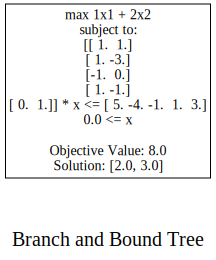

time: 469 ms


<IPython.core.display.Javascript object>

In [4]:
x = cp.Variable((2,), integer=False)
branch_and_bound_ilp(
    x=x,
    constraints=[
        np.array([[1, 1], [1, -3], [-1, 0], [1, -1], [0, 1]]) @ x
        <= np.array([5, -4, -1, 1, 3]),
        x >= 0,
    ],
    obj_coeff=np.array([1, 2]),
    problem_type="max",
)